In [1]:
import pandas as pd
df = pd.read_csv("../data/sentiment_results.csv")

__Pozitif/Negatif/Nötr dağılım grafiklerinin oluşturulması__

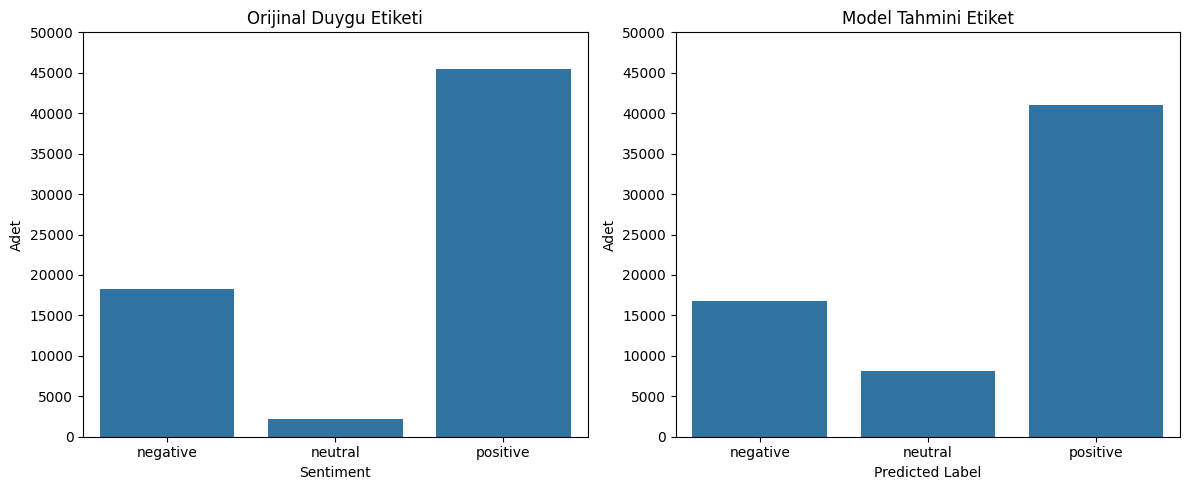

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 5))

yticks = np.arange(0, 50001, 5000) 

plt.subplot(1, 2, 1)
sns.countplot(x='sentiment', data=df)
plt.title("Orijinal Duygu Etiketi")
plt.ylim(0, 50000)
plt.yticks(yticks)
plt.xlabel("Sentiment")
plt.ylabel("Adet")

plt.subplot(1, 2, 2)
sns.countplot(x='normalized_pred_label', data=df)
plt.title("Model Tahmini Etiket")
plt.ylim(0, 50000)
plt.yticks(yticks)
plt.xlabel("Predicted Label")
plt.ylabel("Adet")

plt.tight_layout()
plt.show()


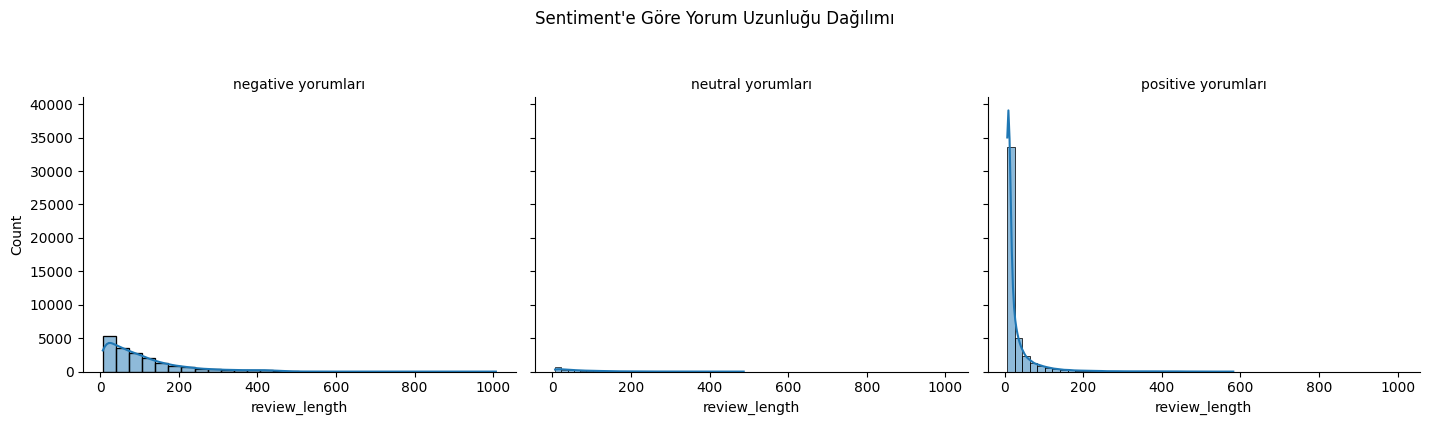

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df, col='sentiment', height=4, aspect=1.2)
g.map(sns.histplot, 'review_length', bins=30, kde=True)
g.set_titles(col_template="{col_name} yorumları")
plt.suptitle("Sentiment'e Göre Yorum Uzunluğu Dağılımı", y=1.05)
plt.tight_layout()
plt.show()


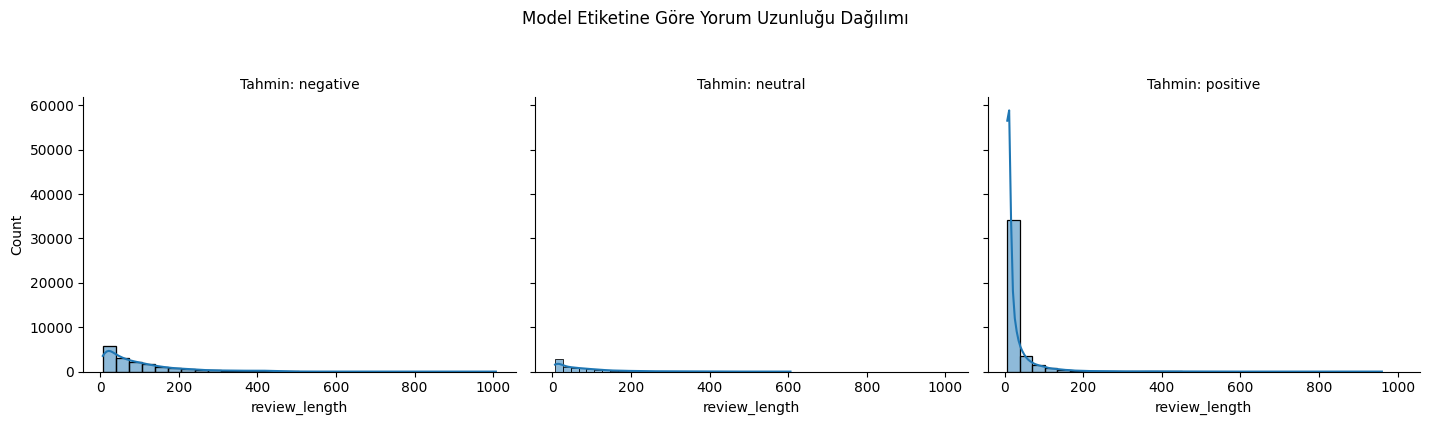

In [4]:
g = sns.FacetGrid(df, col='normalized_pred_label', height=4, aspect=1.2)
g.map(sns.histplot, 'review_length', bins=30, kde=True)
g.set_titles(col_template="Tahmin: {col_name}")
plt.suptitle("Model Etiketine Göre Yorum Uzunluğu Dağılımı", y=1.05)
plt.tight_layout()
plt.show()

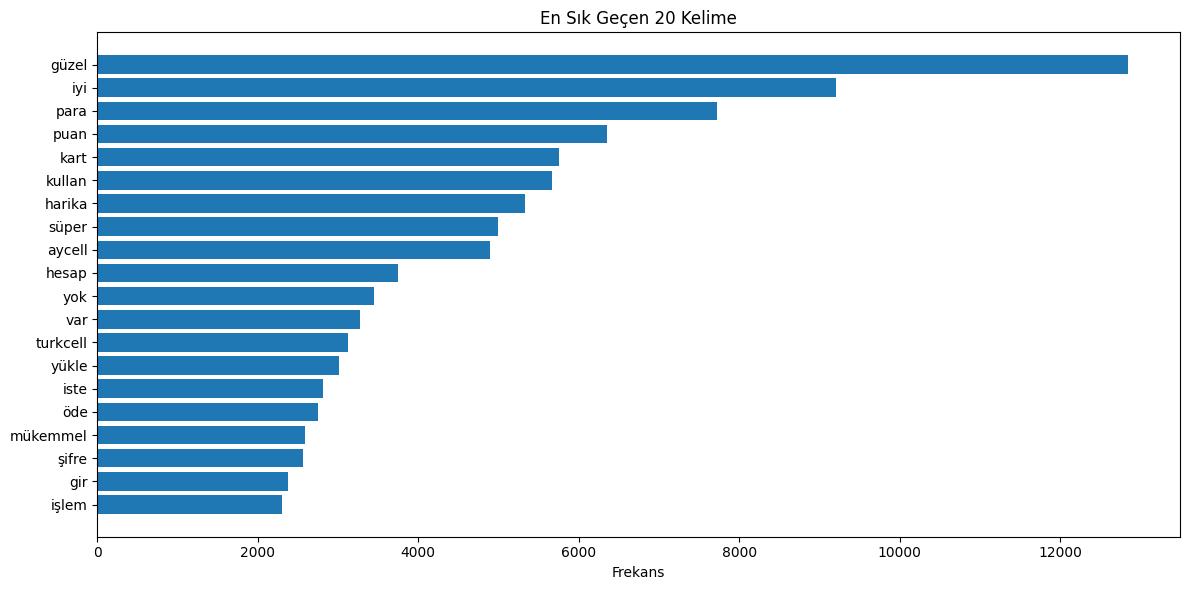

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
import ast

all_words = []
for lem in df['lemmas']:
    words = ast.literal_eval(lem)
    all_words.extend([w.lower().strip() for w in words if w.isalpha()])  

word_freq = Counter(all_words)

top_words = word_freq.most_common(20)

words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.barh(words[::-1], counts[::-1])  
plt.xlabel("Frekans")
plt.title("En Sık Geçen 20 Kelime")
plt.tight_layout()
plt.show()


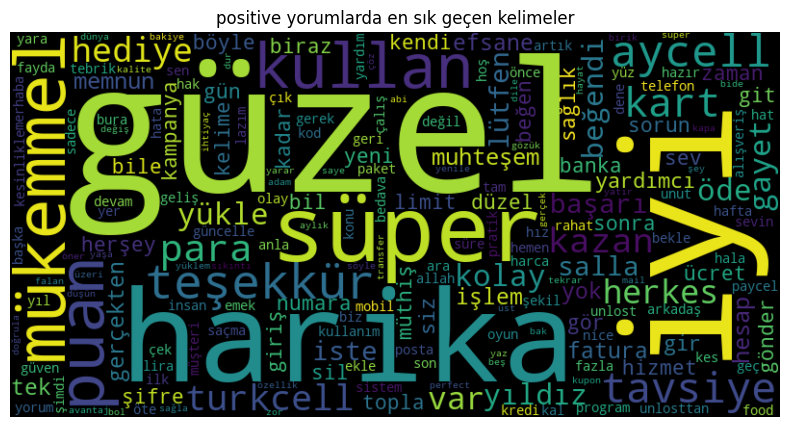

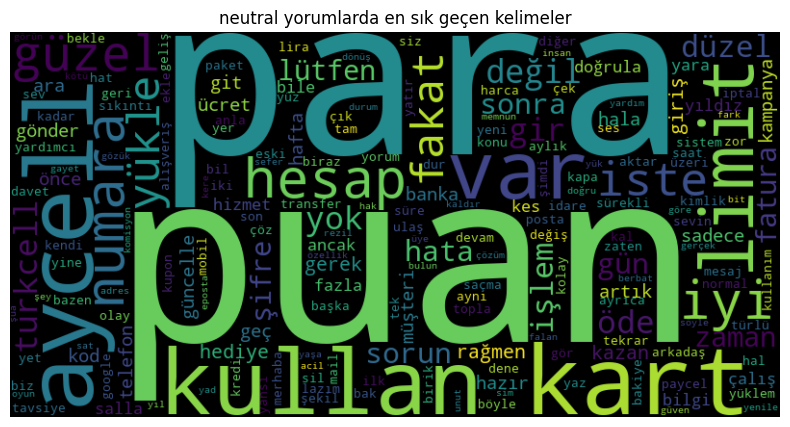

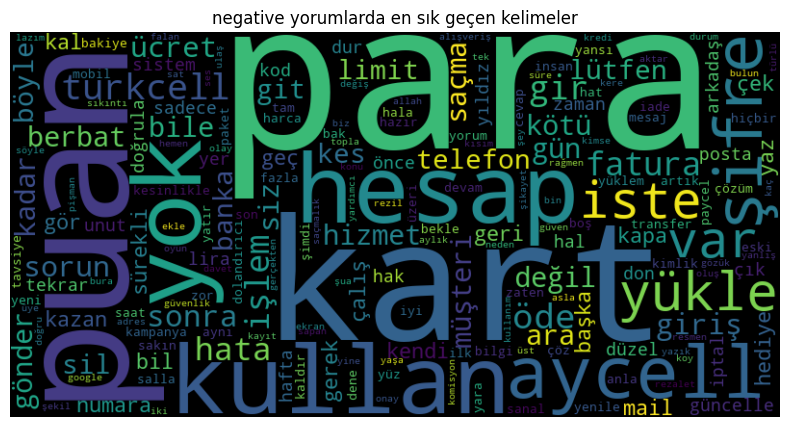

In [6]:
from wordcloud import WordCloud
import ast

for label in ['positive', 'neutral', 'negative']:
    lemmas = df[df['normalized_pred_label'] == label]['lemmas']
    
    all_words = []
    for lem in lemmas:
        try:
            words = ast.literal_eval(lem) if isinstance(lem, str) else lem
            words = [w.lower().strip() for w in words if w.isalpha()]
            all_words.extend(words)
        except:
            continue
    
    text = " ".join(all_words)
    
    wc = WordCloud(width=800, height=400, collocations=False).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{label} yorumlarda en sık geçen kelimeler')
    plt.show()


In [7]:
df["lemmas"]

0        ['şua', 'sorun', 'var', 'banka', 'kart', 'para...
1        ['türlü', 'dekont', 'yer', 'öde', 'dair', 'dek...
2        ['hafta', 'çalışıyum', 'güvenlik', 'anahtar', ...
3                                   ['yabancı', 'doğrula']
4        ['şifre', 'güncelle', 'guncelletmiuorsunuz', '...
                               ...                        
65957                                            ['güzel']
65958    ['mobil', 'öde', 'bakiye', 'işlem', 'tarihçe',...
65959                                          ['besleme']
65960                                       ['fin', 'hit']
65961                ['gayet', 'başarı', 'kullan', 'dost']
Name: lemmas, Length: 65962, dtype: object

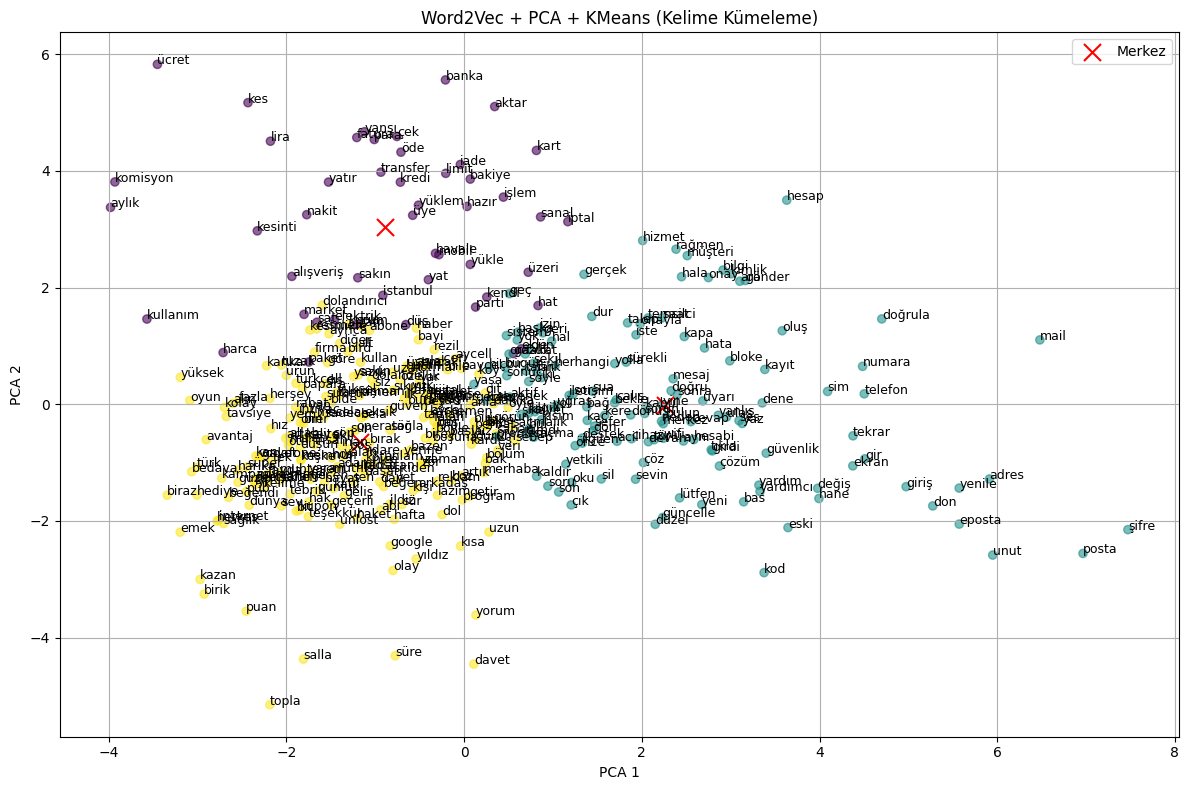

In [8]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

tokenized_docs = df["lemmas"].dropna().apply(ast.literal_eval).tolist()

model = Word2Vec(sentences=tokenized_docs, vector_size=50, window=5, min_count=2, sg=0)
word_vectors = model.wv

words = list(word_vectors.index_to_key)[:400]
vectors = word_vectors[words]

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(vectors)

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)
centers = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=150, label='Merkez')

for i, word in enumerate(words):
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word, fontsize=9)

plt.title("Word2Vec + PCA + KMeans (Kelime Kümeleme)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


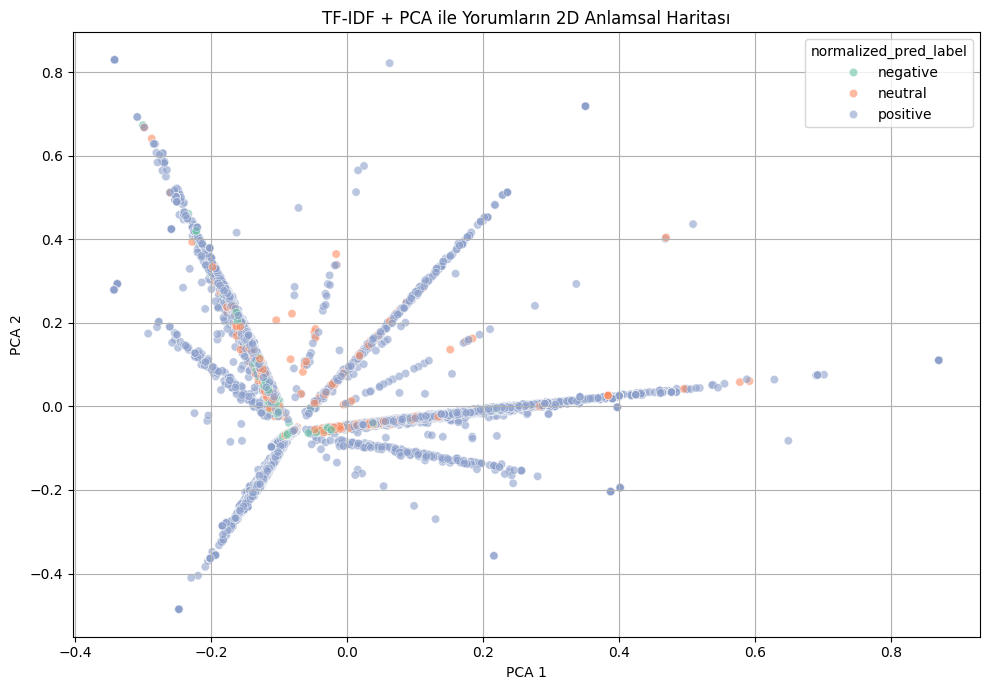

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Temizlenmiş yorum metinlerini birleştir
texts = df['lemmas']

# 2. TF-IDF vektörleri
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(texts)

# 3. PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# 4. Sonuçları DataFrame'e ekle
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

# 5. Scatter plot: yorumlar, sentiment rengine göre
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='pca1', y='pca2',
                hue='normalized_pred_label',  # ya da 'sentiment' kullanabilirsin
                palette='Set2', alpha=0.6)
plt.title('TF-IDF + PCA ile Yorumların 2D Anlamsal Haritası')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: xlabel='Tarih'>

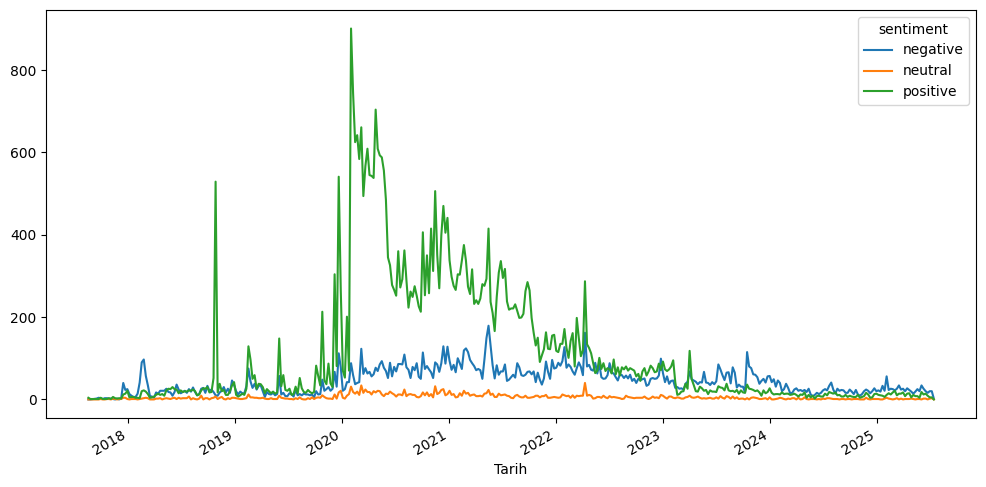

In [10]:
df_temp = df.copy()
df_temp['Tarih'] = pd.to_datetime(df_temp['Tarih'])
df_temp.set_index('Tarih', inplace=True)

df_temp.resample('W')['sentiment'].value_counts().unstack().fillna(0).plot(figsize=(12, 6))


<Axes: xlabel='Tarih'>

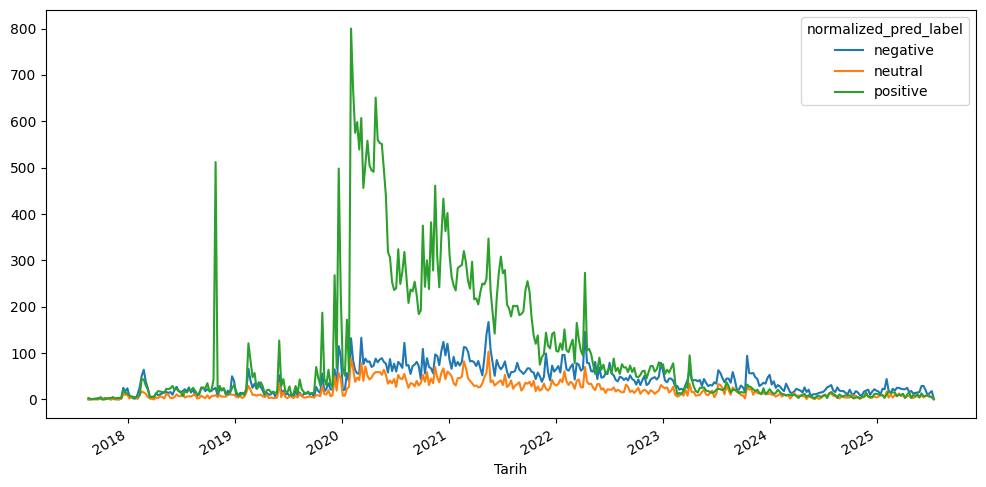

In [11]:
df_temp = df.copy()
df_temp['Tarih'] = pd.to_datetime(df_temp['Tarih'])
df_temp.set_index('Tarih', inplace=True)

df_temp.resample('W')['normalized_pred_label'].value_counts().unstack().fillna(0).plot(figsize=(12, 6))


<Figure size 600x600 with 0 Axes>

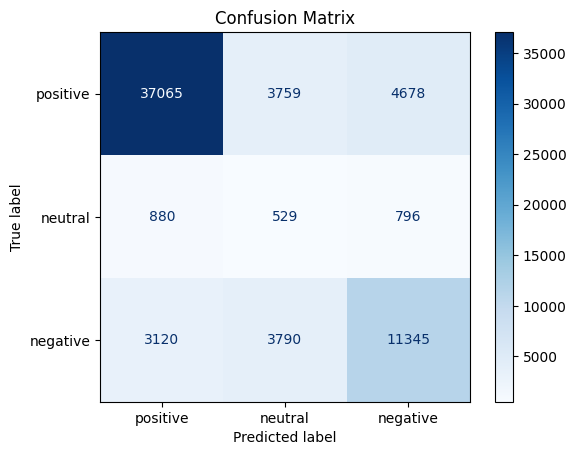

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = df['sentiment']
y_pred = df['normalized_pred_label']

cm = confusion_matrix(y_true, y_pred, labels=["positive", "neutral", "negative"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "neutral", "negative"])

plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


<Figure size 1000x600 with 0 Axes>

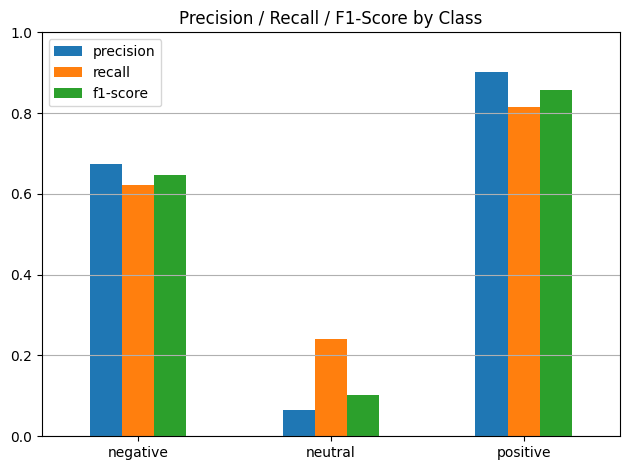

In [13]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:3]  # sadece sınıflar

plt.figure(figsize=(10,6))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title("Precision / Recall / F1-Score by Class")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print(f"Doğruluk (Accuracy): {acc:.2%}")


Doğruluk (Accuracy): 74.19%


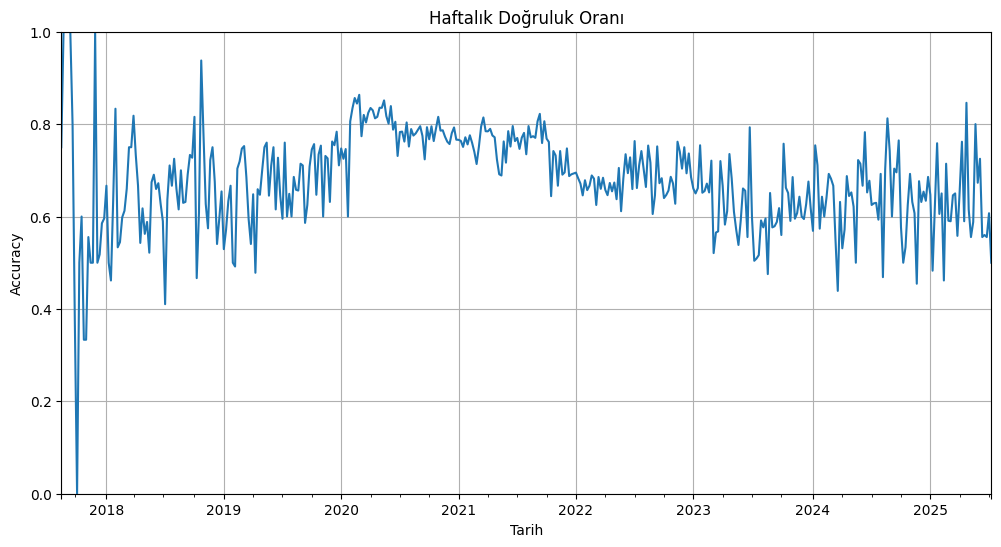

In [15]:
df['correct'] = df['sentiment'] == df['normalized_pred_label']
df['Tarih'] = pd.to_datetime(df['Tarih'])
weekly_acc = df.set_index('Tarih').resample('W')['correct'].mean()

weekly_acc.plot(figsize=(12, 6))
plt.title("Haftalık Doğruluk Oranı")
plt.ylabel("Accuracy")
plt.xlabel("Tarih")
plt.grid(True)
plt.ylim(0, 1)
plt.show()


In [16]:
df

,lemmas,sentiment,review_length,normalized_pred_label,Tarih,pca1,pca2,correct
0,"['şua', 'sorun', 'var', 'banka', 'kart', 'para...",negative,164,negative,2025-07-07 10:25:20,-0.088513,-0.066158,True
1,"['türlü', 'dekont', 'yer', 'öde', 'dair', 'dek...",negative,95,neutral,2025-07-07 09:08:45,-0.083321,-0.061983,False
2,"['hafta', 'çalışıyum', 'güvenlik', 'anahtar', ...",negative,144,positive,2025-07-06 22:22:35,-0.083753,-0.062618,False
3,"['yabancı', 'doğrula']",negative,22,neutral,2025-07-06 20:02:06,-0.078910,-0.057844,False
4,"['şifre', 'güncelle', 'guncelletmiuorsunuz', '...",neutral,52,negative,2025-07-06 18:34:42,-0.080855,-0.059483,False
...,...,...,...,...,...,...,...,...
65957,['güzel'],positive,9,positive,2017-08-25 10:43:11,0.869772,0.110376,True
65958,"['mobil', 'öde', 'bakiye', 'işlem', 'tarihçe',...",positive,82,positive,2017-08-19 15:08:30,0.037418,-0.038710,True
65959,['besleme'],positive,11,neutral,2017-08-17 06:38:45,-0.077569,-0.056436,False
65960,"['fin', 'hit']",positive,14,positive,2017-08-16 20:23:34,-0.077584,-0.056451,True


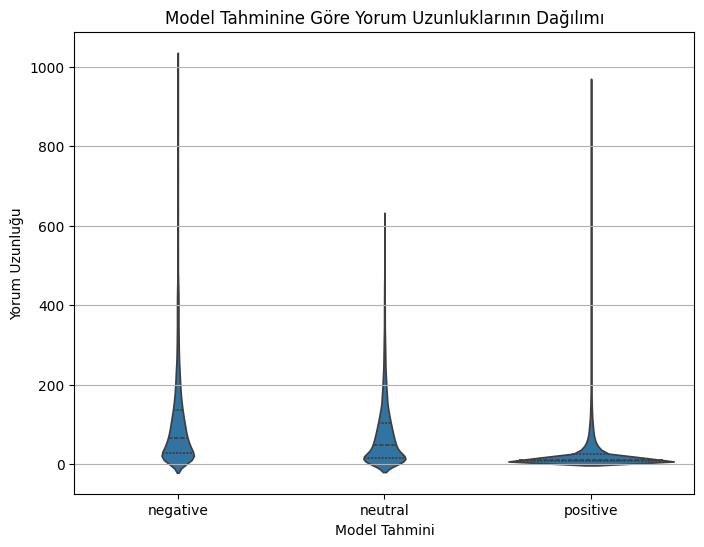

In [17]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='normalized_pred_label', y='review_length', data=df, inner='quartile')
plt.title("Model Tahminine Göre Yorum Uzunluklarının Dağılımı")
plt.xlabel("Model Tahmini")
plt.ylabel("Yorum Uzunluğu")
plt.grid(axis='y')
plt.show()


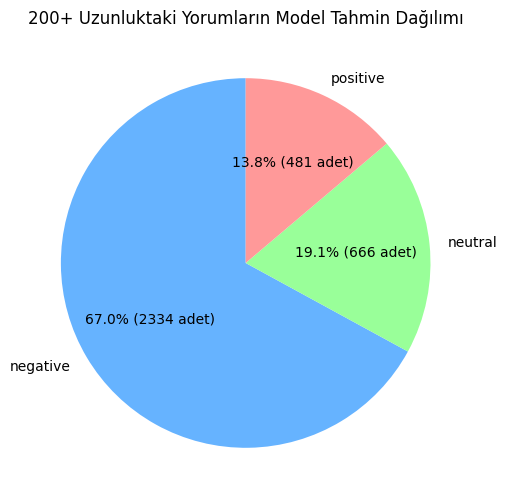

In [18]:
import matplotlib.pyplot as plt

df_200plus = df[df['review_length'] > 200]

counts = df_200plus['normalized_pred_label'].value_counts()
labels = counts.index
sizes = counts.values

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}% ({val} adet)'
    return my_autopct

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=90,
        colors=['#66b3ff', '#99ff99', '#ff9999'])
plt.title("200+ Uzunluktaki Yorumların Model Tahmin Dağılımı")
plt.ylabel("")
plt.show()
